In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from saveload import load_obj
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
import os
import random
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import backend
tf.get_logger().setLevel('ERROR')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from numpy.random import seed
from tensorflow import set_random_seed

In [2]:
seed(17)
set_random_seed(10)

## Prior reading 

Please go through Colah's blog on LSTM [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). Colah's blog explains LSTM are more capable to remember long term dependencies as compared to simple RNN. In this exercise we will see by example how LSTM remembers an information.

## Problem

How LSTM learns to add two binary numbers. We will see how LSTM remembers carry bit. 

## Dataset

In [7]:
train_X = load_obj('bits/train_X')
test_X = load_obj('bits/test_X')
train_y = load_obj('bits/train_y')
train_y = train_y[:,:,-1:]
test_y = load_obj('bits/test_y')
test_y = test_y[:,:,-1:]

### Dataset example

As shown below we see that binary digits in dataset are stored as **Least significant bit first**. Input train sample has 2 binary digits **0011** and **0011** and there sum is expected output of **0110**

Input train sample

In [8]:
print(train_X[0])

[[1 1]
 [1 1]
 [0 0]
 [0 0]]


Corresponding output sample

In [9]:
print(train_y[0])

[[0]
 [1]
 [1]
 [0]]


## Training

In [10]:
model = tf.keras.Sequential()
model.add(layers.LSTM(input_shape=(4, 2), use_bias=True, units=2, return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

total_epochs = 60

def time_decay(epoch):
    initial_lrate, end_lrate = 0.3, 0.09
    decay = (initial_lrate-end_lrate)/total_epochs
    new_lrate = decay * epoch
    return new_lrate

callback = LearningRateScheduler(time_decay)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(train_X, train_y,
          validation_data=(test_X, test_y),
          batch_size=10,
          epochs=total_epochs,
          callbacks=[callback],verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 2)              40        
_________________________________________________________________
dense_1 (Dense)              (None, 4, 1)              3         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
None


## Test accuracy

In [11]:
y_pred = model.predict_classes(test_X)
y_true = test_y[:,:,0]
acc= accuracy_score(y_true.flatten(), y_pred.flatten())
acc

0.99609375

## Check how cell state $C_t$ stores carry

We believe that cell state $C_t$ stores the carry information. We take the trained weights from keras model. We have got cell state when carry is 0 or 1 for each LSTM prediction. 

In [12]:
weightLSTM = model.layers[0].get_weights()
w1 = model.layers[1].get_weights()[0]
b1 = model.layers[1].get_weights()[1]
c_t_list = []
carry_list = []

def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))

# Source : https://stackoverflow.com/questions/52026823/keras-lstm-layer-output-and-the-output-of-a-numpy-lstm-implementation-are-simila
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2) # Previous cell state
    h_tm1 = np.array([0,0]).reshape(1,2) # Previous output
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1 # new cell state
    h_t = o*np.tanh(c_t) # new output
    return(h_t,c_t)

# Simulate prediction and save carry and corresponding cell state info
for j in range(100):
    xs = test_X[j]
    hunits = 2
    c_t = np.array([0]*hunits).reshape(1,hunits)
    h_t = np.array([0]*hunits).reshape(1,hunits)
    carry = 0
    for i in range(len(xs)):
        x_t = xs[i]
        tsum = x_t.sum() + carry
        if tsum==2 or tsum==3:
            carry = 1
        else:
            carry = 0
        h_t,c_t = LSTMlayer(weightLSTM,x_t,h_t,c_t)
        c_t_list.append(c_t)
        carry_list.append(carry)
        
c_t_arr = np.concatenate(c_t_list)

Cell state data and corresponding carry value

In [18]:
df = pd.DataFrame(c_t_arr)
df['carry'] = carry_list
df.columns = ['cell_state_0', 'cell_state_1', 'carry']
df.head()

,cell_state_0,cell_state_1,carry
0,-0.938934,-0.996008,1
1,-0.970816,-1.985624,1
2,-0.900818,-0.910399,1
3,-0.116658,-0.614460,0
4,-0.938934,-0.996008,1


We can see in below scatter plot how cell state saves carry value. Cell states with carry value 1 forms a separate cluster, because which while predicting LSTM can easily classify whether carry value is 1 or 0.

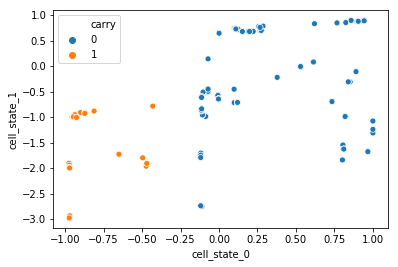

In [19]:
sns.scatterplot(x='cell_state_0', y='cell_state_1', hue='carry',
                data=df)